### The goal of this notebook is to reproduce the results from the original Microsim publication using the newly-developed Person-based code.

In [1]:
import os
import copy
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandarallel import pandarallel
import numpy as np
import matplotlib.pyplot as plt

from microsim.population import NHANESDirectSamplePopulation
from microsim.risk_factor import DynamicRiskFactorsType, StaticRiskFactorsType
from collections import Counter

microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)

### Validation of baseline simulated population

#### 2007-2009 NHANES

In [ ]:
%%time
popSize = 100000
pop = NHANESDirectSamplePopulation(popSize, 2007)

In [ ]:
for i,rf in enumerate(DynamicRiskFactorsType):
    rfList = list(map( lambda x: getattr(x, "_"+rf.value)[-1] if x.is_alive else None, pop._people))
    rfList = list(filter(lambda x: x is not None, rfList))
    rfList = list(map(lambda x: int(x) if bool(x) else x, rfList))
    print(f"{rf.value:>50} {np.mean(rfList):> 6.1f}")
    
for i,rf in enumerate(StaticRiskFactorsType):
    print(f"{rf:>50}")
    rfList = list(map( lambda x: getattr(x, "_"+rf.value), pop._people))
    rfValueCounts = Counter(rfList)
    for key in rfValueCounts.keys():
        print(f"{key:>50} {rfValueCounts[key]/popSize: 6.2f}")

#### 2013, hypertension

In [ ]:
%%time
popSize = 100000
pop = NHANESDirectSamplePopulation(popSize, 2013, filter=lambda x: x.antiHypertensive>0)

In [ ]:
for i,rf in enumerate(DynamicRiskFactorsType):
    rfList = list(map( lambda x: getattr(x, "_"+rf.value)[-1] if x.is_alive else None, pop._people))
    rfList = list(filter(lambda x: x is not None, rfList))
    rfList = list(map(lambda x: int(x) if bool(x) else x, rfList))
    print(f"{rf.value:>50} {np.mean(rfList):> 6.1f}")
    
for i,rf in enumerate(StaticRiskFactorsType):
    print(f"{rf.value:>50}")
    rfList = list(map( lambda x: getattr(x, "_"+rf.value), pop._people))
    rfValueCounts = Counter(rfList)
    for key in rfValueCounts.keys():
        print(f"{key:>50} {rfValueCounts[key]/popSize: 6.2f}")

### Validation of vascular risk factors over time

In [2]:
%%time
popSize = 100000
nYears = 18
pop = NHANESDirectSamplePopulation(popSize, 1999)

CPU times: user 40.1 s, sys: 295 ms, total: 40.4 s
Wall time: 40.4 s


In [3]:
%%time
#1m 47 s
pop.advance_parallel(nYears, None, 5)

CPU times: user 35.7 s, sys: 4.74 s, total: 40.4 s
Wall time: 7min 52s


In [4]:
from microsim.population import microsimToNhanes

nhanesPop = pd.read_stata(microsimDir + "/microsim/data/fullyImputedDataset.dta")
nhanesPop = nhanesPop[~(nhanesPop["timeInUS"]<4)]
nhanesPop = nhanesPop[nhanesPop["year"]==2017]
nhanesPop = nhanesPop[nhanesPop["age"]>=36]

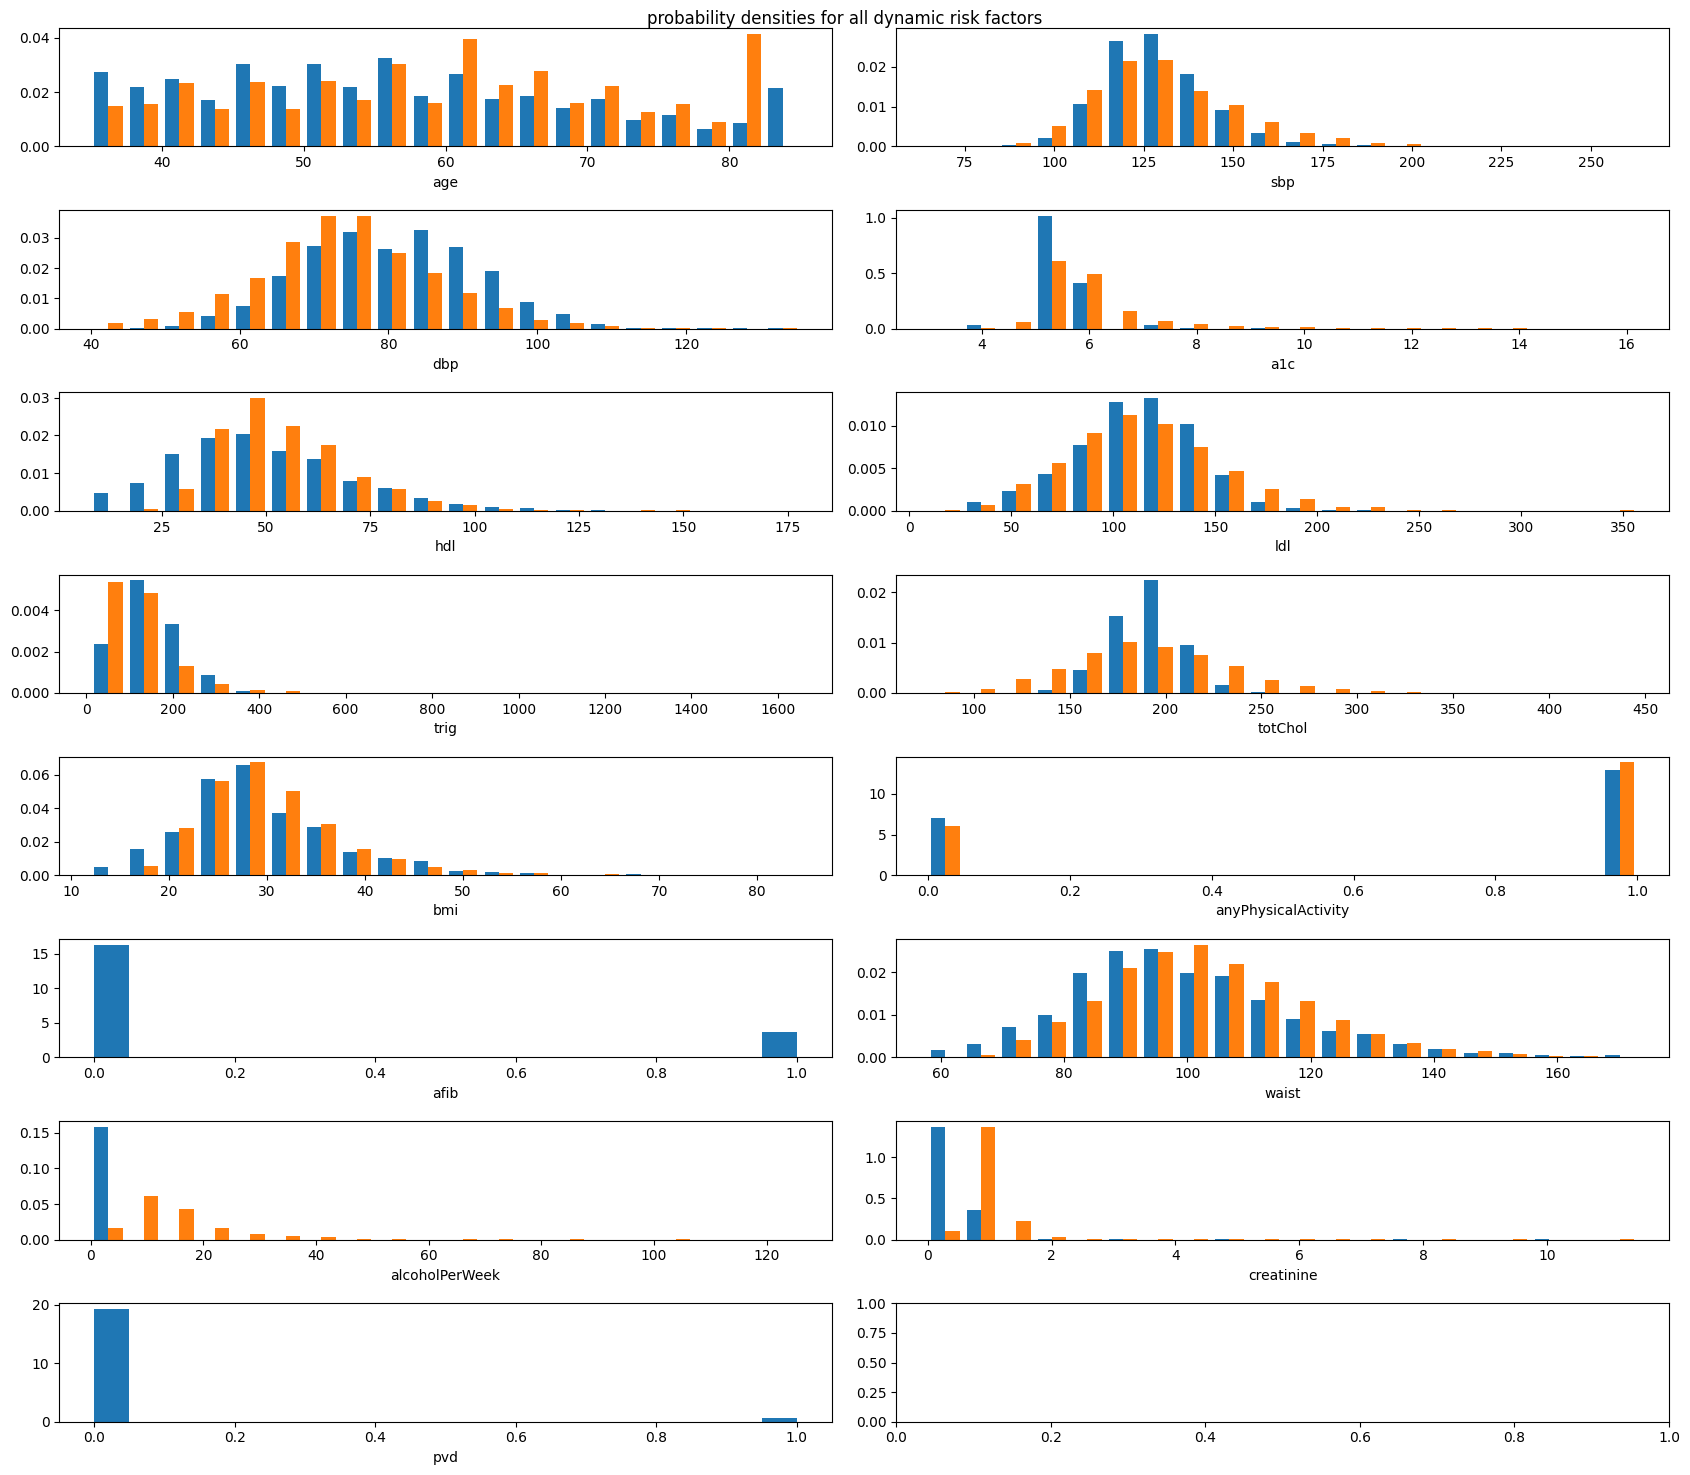

In [5]:
nRows = round(len(DynamicRiskFactorsType)/2)
fig, ax = plt.subplots(nRows, 2, figsize=(17,15))
row=-1
for i,rf in enumerate(DynamicRiskFactorsType):
    rfList = list(map( lambda x: getattr(x, "_"+rf.value)[-1] if x.is_alive else None, pop._people))
    rfList = list(filter(lambda x: x is not None, rfList))
    rfList = list(map(lambda x: int(x) if bool(x) else x, rfList))
    if i%2==0:
        row += 1
        col = 0
    else:
        col = 1
    if rf.value in microsimToNhanes.keys():
        ax[row,col].hist([rfList, nhanesPop[microsimToNhanes[rf.value]]], bins=20, density=True)
    else:
        ax[row,col].hist(rfList, bins=20, density=True)
    ax[row,col].set_xlabel(rf.value)
    #ax[row,col].set_ylabel("probability density")
plt.suptitle("probability densities for all dynamic risk factors")
#plt.subplots_adjust(wspace=0.5, hspace=0.7)
plt.tight_layout()
plt.show()

In [6]:
space = " "
print("                       sim mean   nha mean    sim sd     nha sd")
for i,rf in enumerate(DynamicRiskFactorsType):
    rfList = list(map( lambda x: getattr(x, "_"+rf.value)[-1] if x.is_alive else None, pop._people))
    rfList = list(filter(lambda x: x is not None, rfList))
    rfList = list(map(lambda x: int(x) if bool(x) else x, rfList))
    if rf.value in microsimToNhanes.keys():
        print(f"{rf.value:>20} {np.mean(rfList): 10.2f} {np.mean(nhanesPop[microsimToNhanes[rf.value]]): 10.2f}" + 
             f"{np.std(rfList): 10.2f} {np.std(nhanesPop[microsimToNhanes[rf.value]]): 10.2f}")
    else:
        print(f"{rf.value:>20} {np.mean(rfList): 10.2f} {space:>9} {np.std(rfList): 10.2f}")

                       sim mean   nha mean    sim sd     nha sd
                 age      56.32      59.43     13.69      13.07
                 sbp     129.58     131.21     15.13      20.65
                 dbp      81.17      73.77     11.60      11.94
                 a1c       5.32       6.05      0.62       1.20
                 hdl      49.36      53.65     21.16      16.13
                 ldl     112.24     114.03     30.12      37.59
                trig     152.33     121.37     68.96      91.21
             totChol     191.32     190.69     17.77      42.14
                 bmi      29.60      30.12      8.18       7.15
 anyPhysicalActivity       0.65       0.69      0.48       0.46
                afib       0.18                 0.39
               waist      99.31     102.95     18.17      16.40
      alcoholPerWeek       0.99      14.44      0.39      14.17
          creatinine       0.23       0.94      0.56       0.49
                 pvd       0.03                 0.1

### Validation of CV event incidence and mortality

In [7]:
from microsim.outcome import OutcomeType
outcomes = [OutcomeType.MI, OutcomeType.STROKE, OutcomeType.DEATH, 
            OutcomeType.CARDIOVASCULAR, OutcomeType.NONCARDIOVASCULAR, OutcomeType.DEMENTIA]
standardizedRates = list(map(lambda x: pop.calculate_mean_age_sex_standardized_incidence(x, 2016), outcomes))
standardizedRatesBlack = list(map(
                           lambda x: pop.calculate_mean_age_sex_standardized_incidence(x,2016, lambda y: y._black), 
                           outcomes))
print("standardized rates (per 100,000)    all        black   ")
for i in range(len(outcomes)):
    print(f"{outcomes[i].value:>30} {standardizedRates[i]:> 10.1f} {standardizedRatesBlack[i]:> 10.1f}") 

standardized rates (per 100,000)    all        black   
                            mi      242.7      221.8
                        stroke      197.8      326.5
                         death      749.2      902.5
                            cv      383.8      495.6
                         noncv      686.6      813.8
                      dementia      236.5      520.6


### Validation of dementia incidence

In [ ]:
dementiaIncidentRate = pop.get_raw_incidence_by_age(OutcomeType.DEMENTIA)

In [ ]:
plt.scatter(dementiaIncidentRate.keys(), dementiaIncidentRate.values())
plt.xlabel("age")
plt.ylabel("dementia incidence rate")
plt.show()

In [ ]:
ageDementia = list(map(lambda y: (y._age[-1], len(y._outcomes[OutcomeType.DEMENTIA])>0), 
              list(filter(lambda x: x.is_alive, pop._people))))
nAlive = len(ageDementia)
ageDementia = list(filter(lambda x: x[1]==True, ageDementia))
ageDementia = [int(x[0]) for x in ageDementia]
plt.hist(ageDementia)
plt.xlabel("age")
plt.title(f"dementia cases at end of simulation ({nAlive} Person objects alive)")
plt.show()

### Validation of treatment effects

In [ ]:
from microsim.treatment_strategy_repository import TreatmentStrategyRepository
from microsim.bp_treatment_strategies import AddASingleBPMedTreatmentStrategy, AddNBPMedsTreatmentStrategy
from microsim.treatment import TreatmentStrategiesType, TreatmentStrategyStatus
from microsim.outcome import OutcomeType

popSize = 700000
nYears=5

In [ ]:
%%time
#for bpMedsAdded in [1,2,3,4]:
for bpMedsAdded in [3]:
    treatmentPop = NHANESDirectSamplePopulation(popSize, 1999)
    controlPop = NHANESDirectSamplePopulation(popSize, 1999)
    treatmentStrategies = TreatmentStrategyRepository()
    #treatmentStrategies._repository[TreatmentStrategiesType.BP.value] = AddASingleBPMedTreatmentStrategy()
    treatmentStrategies._repository[TreatmentStrategiesType.BP.value] = AddNBPMedsTreatmentStrategy(bpMedsAdded)
    treatmentPop.advance_parallel(1, treatmentStrategies = treatmentStrategies, nWorkers=5)
    treatmentStrategies._repository[TreatmentStrategiesType.BP.value].status = TreatmentStrategyStatus.MAINTAIN
    treatmentPop.advance_parallel(nYears-1, treatmentStrategies = treatmentStrategies, nWorkers=5)
    controlPop.advance_parallel(nYears, nWorkers=5)
    
    controlRisk = sum(list(map(lambda x: x.has_outcome_during_simulation(OutcomeType.STROKE), 
                           controlPop._people)))/controlPop._n
    treatmentRisk = sum(list(map(lambda x: x.has_outcome_during_simulation(OutcomeType.STROKE), 
                             treatmentPop._people)))/treatmentPop._n
    strokeRR = treatmentRisk/controlRisk
    controlRisk = sum(list(map(lambda x: x.has_outcome_during_simulation(OutcomeType.MI), 
                           controlPop._people)))/controlPop._n
    treatmentRisk = sum(list(map(lambda x: x.has_outcome_during_simulation(OutcomeType.MI), 
                             treatmentPop._people)))/treatmentPop._n
    miRR = treatmentRisk/controlRisk
    print(f"bpMedsAdded={bpMedsAdded}, stroke RR={strokeRR}, mi RR={miRR}")

In [ ]:
#with 1bpmedsadded: 
# ref: 0.79, 0.87
#    for stroke: 0.008045, 0.0063275, 0.7865133623368552
#.   for mi: 0.0121825, 0.01068, 0.876667350707982
#with AddNBPMedsTreatmentStrategy(1)
#  ref: 0.79, 0.87
#.   for stroke: 0.0076975, 0.006165, 0.800909386164339
#.   for mi: 0.012245, 0.0105125, 0.8585136790526745
#with  AddNBPMedsTreatmentStrategy(2)
#.  ref: 0.624, 0.757
#.   for stroke: 0.0079025, 0.0044725, 0.565960139196456
#.   for mi: 0.012265, 0.0090875, 0.7409294741133307
# new params for stroke: 0.6125 for mi 0.74552
#with AddNBPMedsTreatmentStrategy(3)
#.  ref: 0.49, 0.658
#.   for stroke: 0.0077125, 0.003825, 0.495948136142625
#.   for mi: 0.0122675, 0.0079975, 0.6519258202567759
#with AddNBPMedsTreatmentStrategy(4)
#.  ref: 0.389, 0.57
#.   for stroke: 0.00801, 0.0031225, 0.3898252184769039
#.   for mi: 0.0121225, 0.0070625, 0.5825943493503816